In [16]:
from pydantic import BaseModel
from langgraph.graph import StateGraph, MessagesState, START, END


class Profile(BaseModel):
    id: str
    name: str
    segment: str

class Feedback(BaseModel):
    customer_id: str
    comments: list[str]

class Ticket(BaseModel):
    id: str
    status: str
    issue: str

class State(BaseModel):
    messages: list[dict] = []
    profile: Profile | None = None
    feedback: Feedback | None = None
    tickets: list[Ticket] | None = None

# Mocked data function for data retrieval
def get_profile(state):
    messages = state.get("messages", [])
    profile = Profile(id="123", name="Jane", segment="premium")
    messages.append({"role": "system", "content": f"Loaded profile: {profile.name}, segment {profile.segment}"})
    return {"messages": messages, "profile": profile}

def get_feedback(state):
    messages = state.get("messages", [])
    feedback = Feedback(customer_id="123", comments=["Great product!", "Support was slow."])
    messages.append({"role": "system", "content": f"Feedback notes: {len(feedback.comments)} comments"})
    return {"messages": messages, "feedback": feedback}

def get_tickets(state):
    messages = state.get("messages", [])
    tickets = [Ticket(id="t1", status="open", issue="Login failed")]
    messages.append({"role": "system", "content": f"Found {len(tickets)} open tickets"})
    return {"messages": messages, "tickets": tickets}

builder = StateGraph(MessagesState)

builder.add_node("profile", get_profile)
builder.add_node("feedback", get_feedback)
builder.add_node("tickets", get_tickets)
    
builder.add_edge(START, "profile")
builder.add_edge("profile", "feedback")
builder.add_edge("feedback", "tickets")
builder.add_edge("tickets", END)

graph = builder.compile()

user_input = "Provide Jane's tickets"
# Initialize messages as a conversation list
initial_state = {"messages": [{"role": "user", "content": user_input}]}

for step in graph.stream(initial_state, {"recursion_limit": 5}):
    print("--- step ---")
    # Pretty-print the latest system message and structured data
    messages = step.get("messages", [])
    if messages:
        print(f"Last system message: {messages[-1]}")
    # Also print any structured outputs added at this step
    for key in ["profile", "feedback", "tickets"]:
        if key in step:
            print(f"{key.capitalize()} data: {step[key]}")
    """
    Output:
    --- step ---
    Profile data: {'messages': [{'role': 'user', 'content': "Provide Jane's tickets"}, {'role': 'system', 'content': 'Loaded profile: Jane, segment premium'}], 'profile': Profile(id='123', name='Jane', segment='premium')}
    --- step ---
    Feedback data: {'messages': [{'role': 'user', 'content': "Provide Jane's tickets"}, {'role': 'system', 'content': 'Loaded profile: Jane, segment premium'}, {'role': 'system', 'content': 'Feedback notes: 2 comments'}], 'feedback': Feedback(customer_id='123', comments=['Great product!', 'Support was slow.'])}
    --- step ---
    Tickets data: {'messages': [{'role': 'user', 'content': "Provide Jane's tickets"}, {'role': 'system', 'content': 'Loaded profile: Jane, segment premium'}, {'role': 'system', 'content': 'Feedback notes: 2 comments'}, {'role': 'system', 'content': 'Found 1 open tickets'}], 'tickets': [Ticket(id='t1', status='open', issue='Login failed')]}
    """


--- step ---
Profile data: {'messages': [HumanMessage(content="Provide Jane's tickets", additional_kwargs={}, response_metadata={}, id='9235e1eb-82a2-4f92-b50e-5fb8916f4389'), {'role': 'system', 'content': 'Loaded profile: Jane, segment premium'}]}
--- step ---
Feedback data: {'messages': [HumanMessage(content="Provide Jane's tickets", additional_kwargs={}, response_metadata={}, id='9235e1eb-82a2-4f92-b50e-5fb8916f4389'), SystemMessage(content='Loaded profile: Jane, segment premium', additional_kwargs={}, response_metadata={}, id='0ec6a3f3-8005-4de8-80ca-4781c974d1e3'), SystemMessage(content='Loaded profile: Jane, segment premium', additional_kwargs={}, response_metadata={}, id='02b6b260-173f-4d57-b761-7c348e877fdb'), {'role': 'system', 'content': 'Feedback notes: 2 comments'}]}
--- step ---
Tickets data: {'messages': [HumanMessage(content="Provide Jane's tickets", additional_kwargs={}, response_metadata={}, id='9235e1eb-82a2-4f92-b50e-5fb8916f4389'), SystemMessage(content='Loaded prof

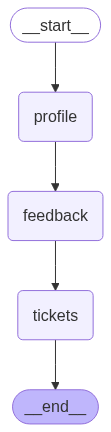

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Optional: install graphviz and Mermaid dependencies for rendering.")